
Simulation-based Inference (SBI) on a Mean-Field Model (MFM) of spiking neurons, developed by Montbrio et al., PRX 2015 (see https://arxiv.org/pdf/1506.06581.pdf). 



In this notebook, we consider an ODE form of equations with Sin input current, and we train SNPE (with a single of round; amortized) to infer the posterior of model parameters from low-dimentional data features.  For more details see Gonçalves et al., elife 2020 and Hashemi et al., Neural Networks 2023. For installation of SBI see: https://github.com/sbi-dev/sbi



In [1]:
import os
import sys
import time
import errno

import numpy as np
import scipy as scp
import pandas as pd
import seaborn as sns

In [2]:
import numba
from numba import jit

In [3]:
import torch
import sbi
import sbi.inference
from sbi.inference import SNPE, prepare_for_sbi ,simulate_for_sbi
from sbi.inference.base import infer
from sbi.analysis import ActiveSubspace, pairplot
import sbi.utils as utils

In [4]:
# visualization
import matplotlib as mpl
import matplotlib.pyplot as plt

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.colors as mcolors
from IPython.display import HTML

In [5]:
from typing import Any, Callable, Dict, List, Optional, Tuple, Union, cast

In [6]:
%pylab inline
#%matplotlib notebook

plt.style.use('seaborn-talk');

plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['axes.edgecolor']='#333F4B'
plt.rcParams['axes.linewidth']=0.8
plt.rcParams['xtick.color']='#333F4B'
plt.rcParams['ytick.color']='#333F4B'

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


/home/meysam/.local/lib/python3.8/site-packages/IPython/core/magics/pylab.py:162: UserWarning: pylab import has clobbered these variables: ['cast']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +
/tmp/ipykernel_18933/94587667.py:4: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-talk');


In [7]:
print(f"Numpy version: {np.__version__}")
print(f"Numba version: {numba.__version__}")
print(f"Matplotlib` version: {matplotlib.__version__}")
print(f"Pandas version: {pd.__version__}")
print(f"SciPy version: {scp.__version__}")
print(f"SBI version: {sbi.__version__}")

Numpy version: 1.24.4
Numba version: 0.57.1
Matplotlib` version: 3.7.1
Pandas version: 2.0.2
SciPy version: 1.10.1
SBI version: 0.21.0


In [8]:
cwd = os.getcwd()
cwd

'/mnt/0582b5ea-dc43-4c17-8a69-29b39f3fc394/SBI/MPR_NMM_SBI'

In [9]:
Res_dir='Res_SBI_NMM_MPR_ODE_Isin_Vfeatures_sumstatspeaks_100ksims_v21'

In [10]:
import warnings
warnings.filterwarnings("ignore")

### Fast Simulation of Montbrio model using numba.jit


$\dfrac{dr}{dt} = 2rv +\Delta/\pi$

$ \dfrac{dv}{dt} = v^2  -\pi^2 r^2 + Jr+ \eta +I(t) $


In [11]:
def Montbrio_ODEmodel(params, constants, I_input, dt, ts):
   
    #parameters
    delta, eta, J  = params[0], params[1], params[2]
    sigma=0.0
    dt = float(dt) #Euler inetgration

    # simulation from initial point
    v = np.zeros_like(ts)  # membrane potential
    r = np.zeros_like(ts)  # firing rate

    # fixed parameters (initial conditions)
    v_init, r_init=constants[0], constants[1]
    v[0],r[0]= v_init, r_init

    for i in range(1, ts.shape[0]):
        dr =(delta/np.pi) +2.*r[i-1]*v[i-1]
        dv = v[i-1]**2  -(np.pi*r[i-1])**2 + J*r[i-1]+ eta +I_input[i-1]
        v[i]=v[i-1] + dt * dv + np.sqrt(dt) * sigma * np.random.randn() 
        r[i]=r[i-1] + dt * dr + np.sqrt(dt) * sigma * np.random.randn() 
        
    return np.concatenate((np.array(v).reshape(-1), np.array(r).reshape(-1),))
     

In [12]:
Montbrio_ODEmodel_numba = numba.jit(Montbrio_ODEmodel)

In [13]:
# set the model key parameters that we aim to infer 

delta=0.7
eta=-4.6
J=14.5

params=[delta, eta, J]

In [14]:
# set the initial and final times, and time steps for euler integration

t_init = 0.0
t_final = 100.0

dt = 0.001
ts = np.arange(t_init,t_final,dt)

nt=ts.shape[0]

In [15]:
# Set the parameters of input current

I0=3.
omega=np.pi/20

I_input=I0*sin(omega*ts)

In [16]:
# set the initial conditions as constants

v0 = -3.0
r0 = 0.5

constants=[v0, r0]

Run Montbrio_ODEmodel

In [17]:
start_time = time.time()

rv = Montbrio_ODEmodel(params, constants, I_input, dt, ts)

print ("-"*60)
print("--- running took: %s seconds ---" % (time.time() - start_time))

------------------------------------------------------------
--- running took: 0.5802388191223145 seconds ---


first run using JIT numba takes time due to compilation, but then in is in fly!

In [18]:
start_time = time.time()

rv = Montbrio_ODEmodel_numba(params, constants, I_input, dt, ts)

print ("-"*60)
print("---running took: %s seconds ---" % (time.time() - start_time))

------------------------------------------------------------
---running took: 1.60966157913208 seconds ---


In [19]:
start_time = time.time()

rv = Montbrio_ODEmodel_numba(params, constants, I_input, dt, ts)

print ("-"*60)
print("--- running took: %s seconds ---" % (time.time() - start_time))

------------------------------------------------------------
--- running took: 0.009475469589233398 seconds ---


Plot the membrane potential v and firing rate r

In [20]:
v=rv[0:nt]
r=rv[nt:2*nt]

In [21]:
ts.shape, v.shape, r.shape

((100000,), (100000,), (100000,))

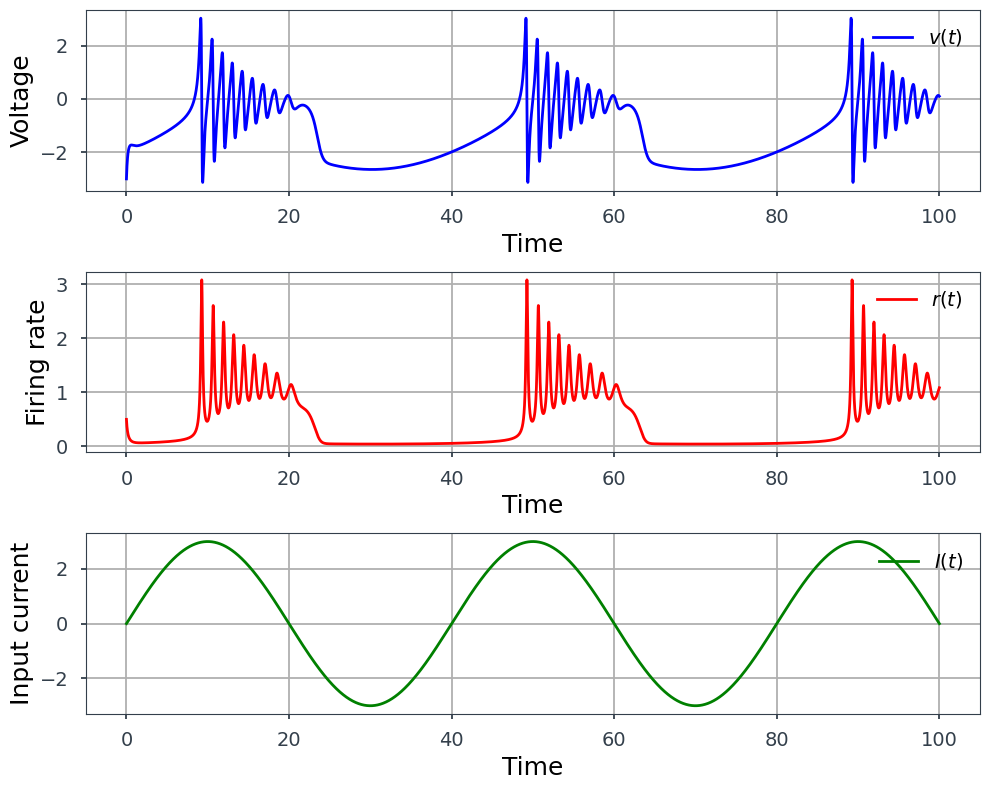

In [22]:
plt.figure(figsize=(10, 8))

plt.subplot(311)
plt.plot(ts, v, 'b', linewidth=2, label='$v(t)$')
plt.xlabel('Time', fontsize=18); plt.ylabel('Voltage', fontsize=18); 
plt.legend(loc='upper right', fontsize=14, frameon=False)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()
plt.grid()

plt.subplot(312)
plt.plot(ts, r, 'r', linewidth=2, label='$r(t)$')
plt.xlabel('Time', fontsize=18); plt.ylabel('Firing rate', fontsize=18); 
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(loc='upper right', fontsize=14, frameon=False)
plt.tight_layout()
plt.grid()

plt.subplot(313)
plt.plot(ts, I_input, 'g', linewidth=2, label='$I(t)$')
plt.xlabel('Time', fontsize=18); plt.ylabel('Input current', fontsize=18); 
plt.legend(loc='upper right', fontsize=14, frameon=False)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()
plt.grid()
plt.savefig(os.path.join(cwd+'/'+str(Res_dir), "Monbtbrio_NMM_ode_Isin.png"), dpi=300)
plt.show()

### Extract data Features

we focus on the summary statistics (mean, std, median, skew, kurtosis) as well as the peaks.

In [23]:
from scipy.signal import  find_peaks

In [24]:
#we devide the signal in three segmenets

t_on=t_final/3
t_off=t_final*(2/3)

In [25]:
v_act=v[(ts > t_on) & (ts < t_off)]
peaks_act, _ = find_peaks(v_act, height=.2, distance=1000)
peaks_act

array([15809, 17196, 18457, 19678, 20899, 22148, 23459, 24882])

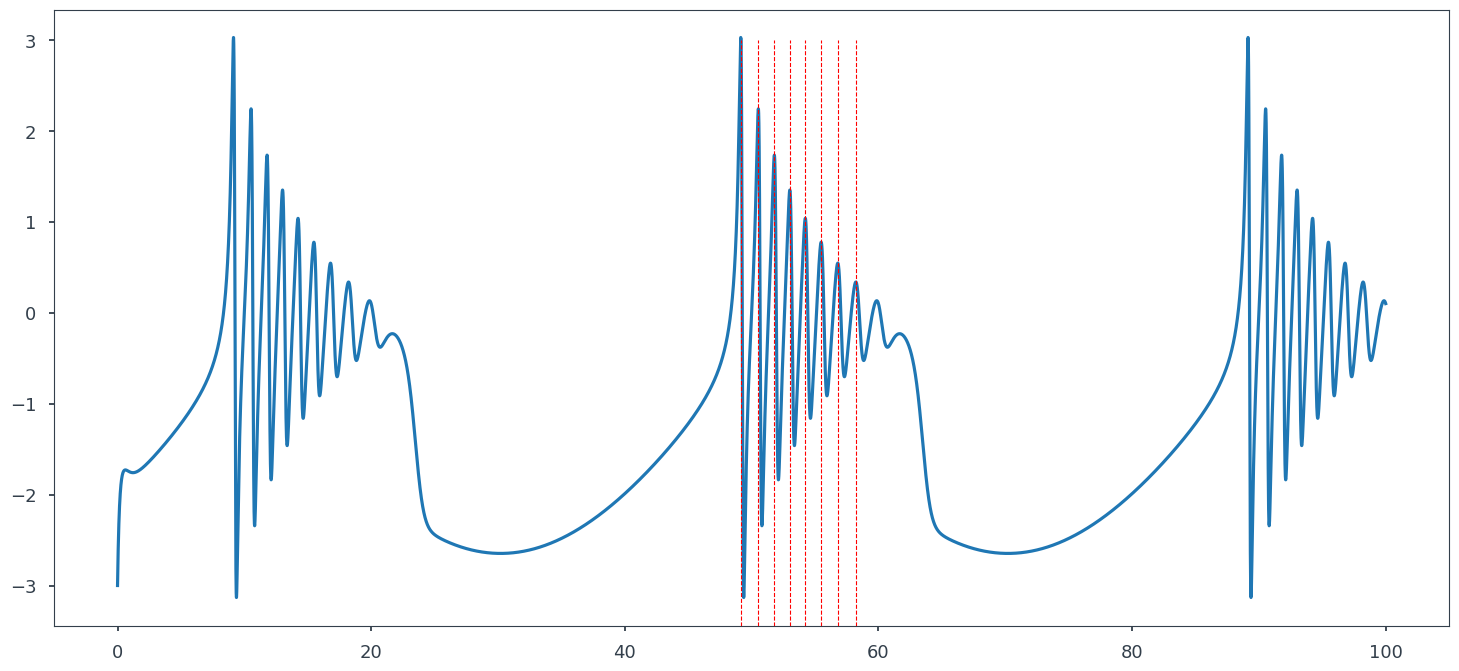

In [26]:
plt.figure(figsize=(18, 8))
plt.plot(ts,v)
for i in np.r_[0:len(peaks_act)]:
     plt.axvline(x=t_on+dt*peaks_act[i], ymin=0, ymax=0.95, linewidth=.8, color = 'r', linestyle='--')
plt.show()

In this notebook we use this function to calculate summary statistics and (mean, std, median, skew, kurtosis) in three segmeents, in addition to the first peaks and the number of peaks in the entire time series, which in total returns 17 elements for each time series.

In [27]:
from MPR_NMM_sumstats import calculate_summary_statistics

In [28]:
_=calculate_summary_statistics(v, dt, ts, t_on, t_off)
_.shape

(17,)

In [29]:
_

array([-1.1299907 ,  1.20642054, -1.1498862 ,  0.40491866, -0.44127847,
       -1.07413198,  1.14123363, -1.1498888 ,  0.53333235, -0.23894838,
       -1.33228659,  1.22511566, -1.61541839,  0.76188928, -0.18595559,
        8.        , 49.14233333])

To make Bayesian SBI, we need three elements:

1) Simulator that takes parameters as input and returns data features as output.

2) Prior, which defines the plausible range based on the background knowledge, to draw random samples for parameters, as the input to simulator.

3) Inference step on observed data, which we train a deep neural density estimator on data features and approximate posterior for the set of observed data.


## 1. Simulator

The follwoing wrapper takes only parameters as the input and return the features (summary statistics) or raw time series as the output, the later case if we like to save the simulations on a supercomputer and then load them on desktop and calculate the corresponding features. In this notebook we do online simuation; so we are interested on only the data features.

In [30]:
def Montbrio_ODEmodel_Wrapper(params):

    params = np.asarray(params)
    
    t_init = 0.0
    t_final = 100.0

    dt = 0.001
    ts = np.arange(t_init,t_final,dt)
    nt=ts.shape[0]

    t_on=t_final/3
    t_off=t_final*(2/3)

    I0=3.
    omega=np.pi/20
    I_input=I0*sin(omega*ts)

    v0 = -3.0
    r0 = 0.5
    
    constants=[v0, r0]
    
    rv = Montbrio_ODEmodel_numba(params, constants, I_input, dt, ts)
    v=rv[0:nt]
    
    summstats = torch.as_tensor(calculate_summary_statistics(v.reshape(-1), dt, ts, t_on, t_off))
    
    return summstats

Sanity check:

In [31]:
params_=[0.7, -4.6, 14.5]

Montbrio_ODEmodel_Wrapper(params_).shape

torch.Size([17])

## 2. Prior over model parameters


Here we set the prior as uniform for all three parameters delta, eta, and J. Note that delta and J are positive whereas eta is negative.

In [32]:
prior_min = [0.1, -10., 5.0]
prior_max = [5.0, -3.0, 20.]
prior = utils.torchutils.BoxUniform(low=torch.as_tensor(prior_min), high=torch.as_tensor(prior_max))

if we use prior.sample(), we get a random sample from prior with the shape of the set parameter of ineterst.

In [33]:
prior.sample().tolist()

[2.724364995956421, -4.026951313018799, 8.361406326293945]

In [34]:
prior_samples=np.stack([prior.sample().tolist() for _ in range(1000)], axis=0)
prior_samples.shape

(1000, 3)

In [35]:
num_params=prior.sample().shape[0]
num_params

3

### 3. Inference

Now we run the inferece step. To do so, we run a budget of random simulations; for each the data feature is calculated, and then an algorithm such as SNPE lerans the relationship between the data features and paranateners of an approximated posterior.

In [36]:
#this is the budget of our simulation for training SNPE with a single of round to benifit from amortized strategy; it means with train once, and then we can fit any data we wish without re-training.

num_sims=100000

In [37]:
# 1-step simualtion, calculation of features, and inference

start_time = time.time()

posterior = infer(Montbrio_ODEmodel_Wrapper, prior, method='SNPE', num_simulations=num_sims, num_workers=1)

print ("-"*60)
print("--- %s seconds ---" % (time.time() - start_time))

Running 100000 simulations.:   0%|          | 0/100000 [00:00<?, ?it/s]

 Neural network successfully converged after 139 epochs.------------------------------------------------------------
--- 4075.4430623054504 seconds ---


### Observed Data

This is set of observed data that we aim to fit; i.e., generated by ground-truth parameters. Note that so far, we did not needed any observed data as the training was performed for the budget of random situations, rather than a specific observed data.

In [38]:
params_label=np.array(['$\Delta$', '$\eta$', '$J$'])

In [39]:
delta_true=0.7
eta_true=-4.6
J_true=14.5

true_params = np.array([delta_true, eta_true, J_true])

In [40]:
x_obs= Montbrio_ODEmodel_numba(true_params, constants, I_input, dt, ts)
v_obs=x_obs[0:nt]
r_obs=x_obs[nt:2*nt]
x_obs_summary_statistics=calculate_summary_statistics(v_obs.reshape(-1), dt, ts, t_on, t_off)

In [41]:
x_obs_summary_statistics.shape

(17,)

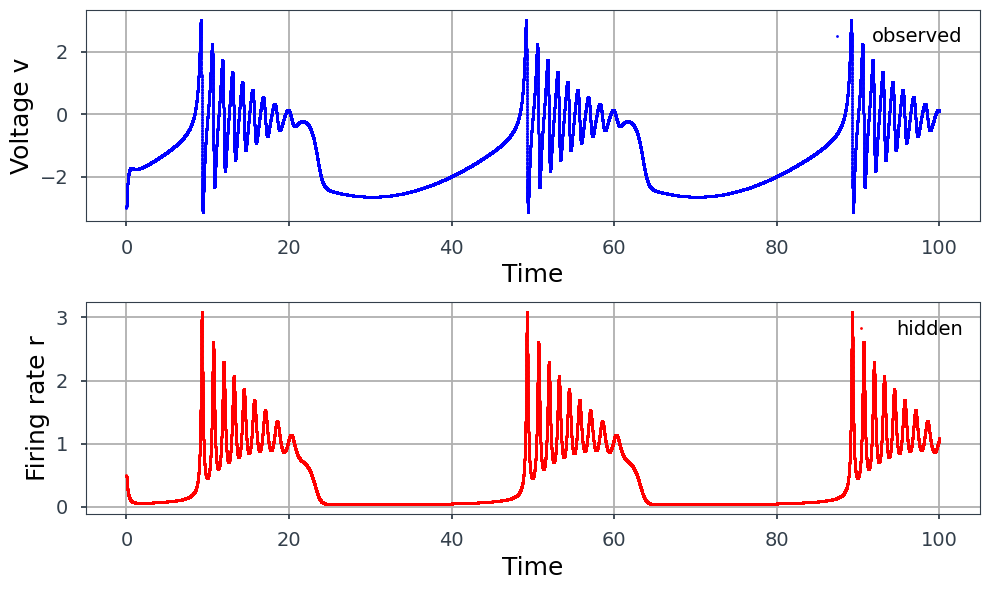

In [42]:
plt.figure(figsize=(10, 6))
plt.subplot(211)
plt.plot(ts, v_obs, '.',  markersize=4, color='blue', label='observed')
plt.xlabel('Time', fontsize=18)
plt.ylabel('Voltage v', fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(loc='upper right',fontsize=14, frameon=False)
plt.tight_layout()
plt.grid()

plt.subplot(212)
plt.plot(ts, r_obs, '.',  markersize=4, color='red',label='hidden')
plt.xlabel('Time', fontsize=18)
plt.ylabel('Firing rate r',fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(loc='upper right', fontsize=14, frameon=False)
plt.tight_layout()
plt.grid()
plt.savefig(os.path.join(cwd+'/'+str(Res_dir), "Monbtbrio_NMM_ode_Isin_obsI.png"), dpi=300)
plt.show()

### Posterior sampling

No we sample from joint posterior given the data features of observed data. Note that this should be the exact dimension as we trained the SNPE (in this notebook 17 elements in data features). The sampling is fast, so it does not matter we take 1k or 10k samples from posterior. The dimention of posterior will be: (number of samples, number of parameters).

In [43]:
num_samples=10000

In [44]:
start_time = time.time()

posterior_samples = posterior.sample((num_samples,), x_obs_summary_statistics).numpy()

print ("-"*60)
print("--- posterior sampling took: %s seconds ---" % (time.time() - start_time))

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

------------------------------------------------------------
--- posterior sampling took: 0.06553268432617188 seconds ---


In [45]:
posterior_samples.shape

(10000, 3)

In [46]:
delta_est=posterior_samples[:,0]
eta_est=posterior_samples[:,1]
J_est=posterior_samples[:,2]

In [47]:
print("delta_est=", delta_est.mean())
print("eta_est=", eta_est.mean())
print("J_est=", J_est.mean())

delta_est= 0.69312376
eta_est= -4.584843
J_est= 14.443861


Now we use the violin plot for visualization; the red is the ground truth that we used to generate the observed data. Ideally, the posterior is centered around the ground-truth if not multimodal, with proper value of shrinkages. Genrally speaking, the more number of simulations and more informative data features will provide the more posterior shrinkage (but there will a limit for this, as we do not expect to get the posatrior as a delta dirac!!!).

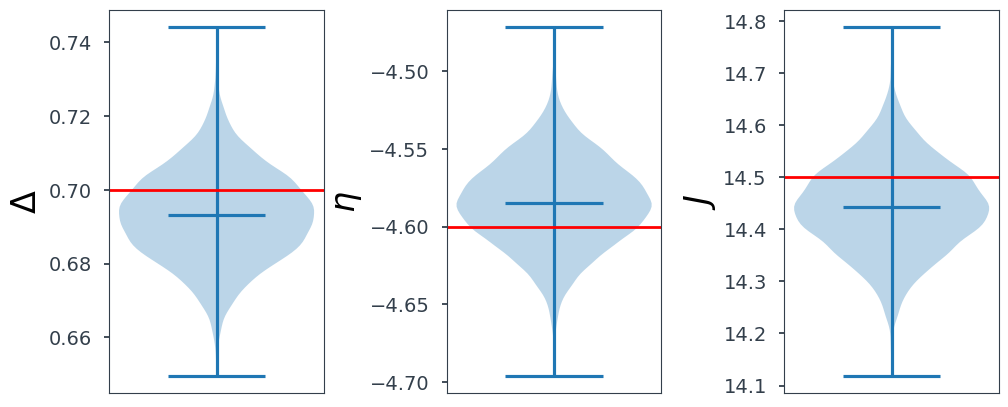

In [48]:
plt.figure(figsize=(10, 4))
for i, variables in enumerate([delta_est, eta_est, J_est]):
    plt.subplot(1,params_label.shape[0],i+1)
    plt.violinplot(variables, widths=0.7, showmeans=True, showextrema=True);
    plt.axhline(y=true_params[i], linewidth=2, color='r')
    plt.ylabel(str(params_label[i]), fontsize=24)   
    plt.xticks([])
    plt.yticks(fontsize=14)
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir), "PosteriorViloin_Monbtbrio_NMM_ode_Isin_EstimatedParams_obs.png"), dpi=300)
plt.show()

And here a KDE on the SBI posterior, and their MAP estimations (in cyan color).  

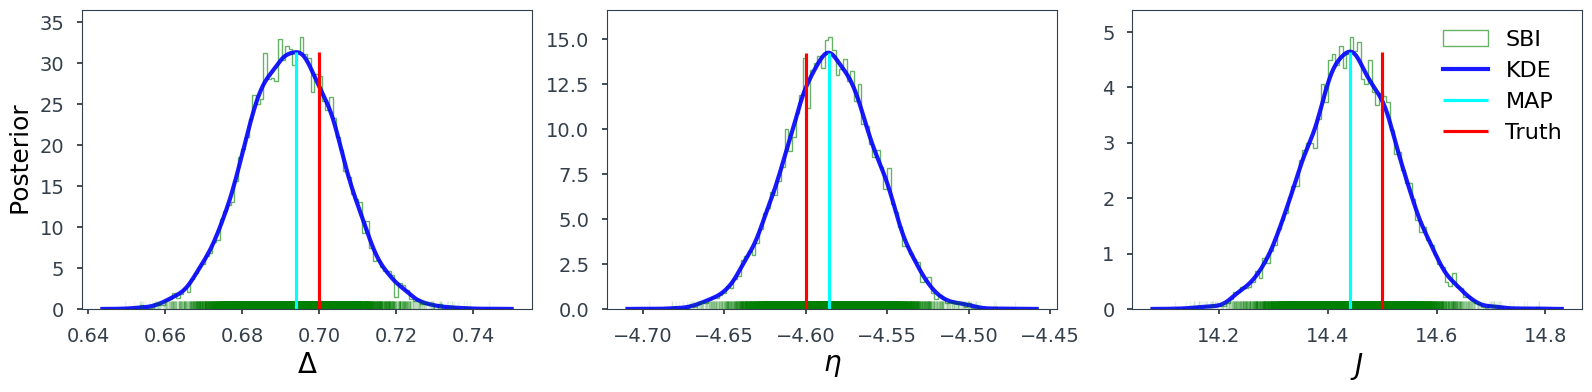

In [49]:
plt.figure(figsize=(16, 4))

for i in range (num_params): 
    ax = plt.subplot(1, 3, i + 1)
    ax=sns.distplot(posterior_samples[:,i], bins=100, hist=True, kde=True, rug=True, rug_kws={"alpha": 0.1, "color": "g"},
                  kde_kws={"color": "b", "alpha": 0.9, "lw": 3, "label": "KDE"},
                  hist_kws={"histtype": "step", "linewidth": 1, "alpha": 0.6, "color": "g"},
                  label='SBI')

    x_ = ax.lines[0].get_xdata()
    y_ = ax.lines[0].get_ydata()
    ymax = max(y_)
    xpos = np.argmax(y_, axis=0)
    xmax = x_[xpos]
    plt.vlines(x=xmax, ymin=0., ymax=y_.max(), colors='cyan', label='MAP')
    plt.vlines(x=true_params[i], ymin=0., ymax=y_.max(), colors='r', label='Truth')

    plt.xlabel(str(params_label[i]), fontsize=20)   
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)

    if i==0:
        plt.ylabel(' Posterior ', fontsize=18);  
    else:
        plt.ylabel('')
        
    if i==2:
            plt.legend(fontsize=16, frameon=False)
 
plt.tight_layout(pad=1.0)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir), "Posterior_Monbtbrio_NMM_ode_Isin_EstimatedParams_obsI.png"), dpi=300)
plt.show()

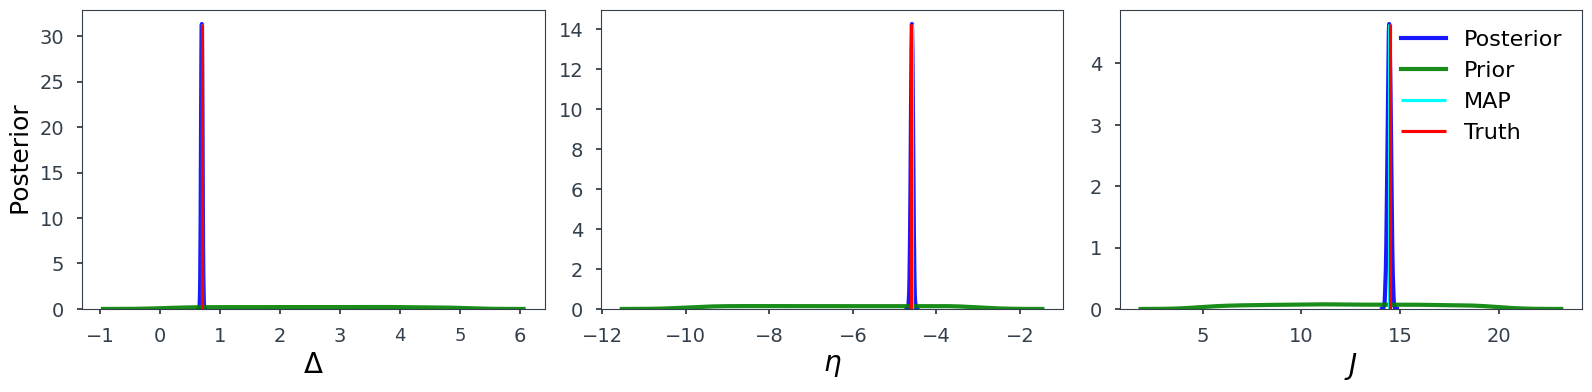

In [50]:
plt.figure(figsize=(16, 4))

for i in range (num_params): 
    ax = plt.subplot(1, 3, i + 1)
    
   
    ax=sns.distplot(posterior_samples[:,i], bins=100, hist=False, kde=True, rug=False, rug_kws={"alpha": 0.1, "color": "g"},
                  kde_kws={"color": "b", "alpha": 0.9, "lw": 3, "label": "Posterior"})
    
    ax_=sns.distplot(prior_samples[:,i], bins=100, hist=False, kde=True, rug=False, rug_kws={"alpha": 0.1, "color": "g"},
                  kde_kws={"color": "g", "alpha": 0.9, "lw": 3, "label": "Prior"})

    x_ = ax.lines[0].get_xdata()
    y_ = ax.lines[0].get_ydata()
    ymax = max(y_)
    xpos = np.argmax(y_, axis=0)
    xmax = x_[xpos]
    plt.vlines(x=xmax, ymin=0., ymax=y_.max(), colors='cyan', label='MAP')
    plt.vlines(x=true_params[i], ymin=0., ymax=y_.max(), colors='r', label='Truth')

    plt.xlabel(str(params_label[i]), fontsize=20)   
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)

    if i==0:
        plt.ylabel(' Posterior ', fontsize=18);  
    else:
        plt.ylabel('')
        
    if i==2:
            plt.legend(fontsize=16, frameon=False)
 
plt.tight_layout(pad=1.0)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir), "Posterior_Monbtbrio_NMM_ode_Isin_EstimatedParamswithPrior_obsI.png"), dpi=300)
plt.show()

And here the joint posterior distribution

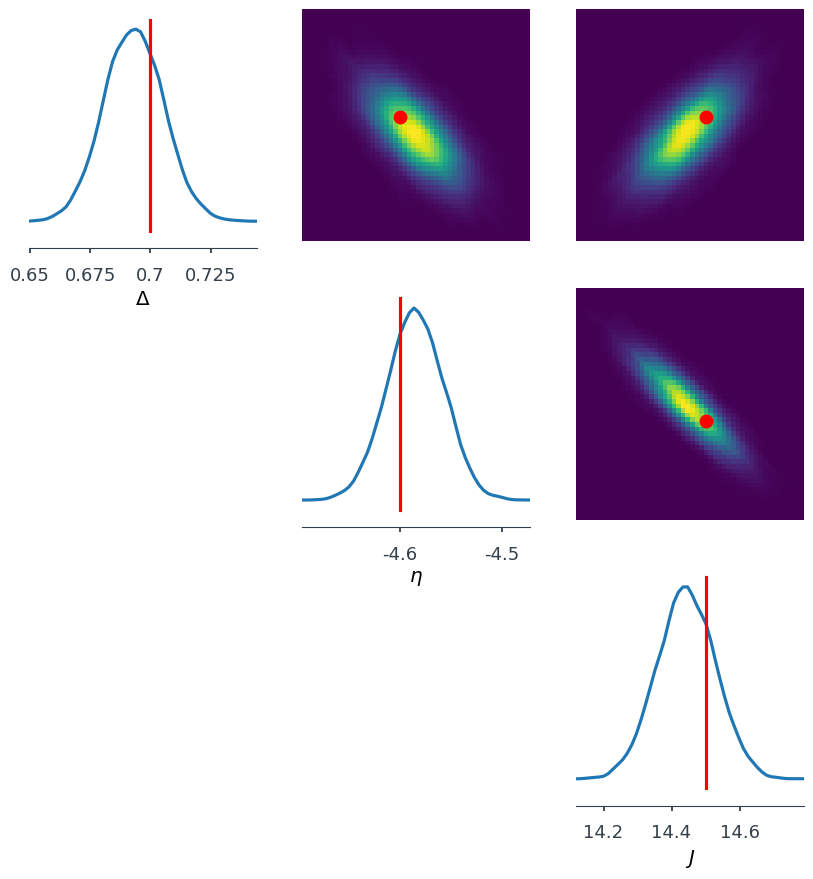

In [51]:
fig, axes = pairplot(posterior_samples,
                           fig_size=(8,8),
                           labels=params_label,
                           upper=['kde'],
                           diag=['kde'],
                           points=true_params,
                           points_offdiag={'markersize': 20},
                           points_colors='r');
plt.savefig(os.path.join(cwd+'/'+str(Res_dir), "Monbtbrio_NMM_ode_Isin_posterior_pairplot_obsI.png"), dpi=300)
plt.show()

Here by the scatter plot of joint posterior we see a high linear relationship between parameters eta and J, which can be imporoved by including the feature of firing rate (directly, or indirectly using time-delay embedding to reconstruct full state-space representation).

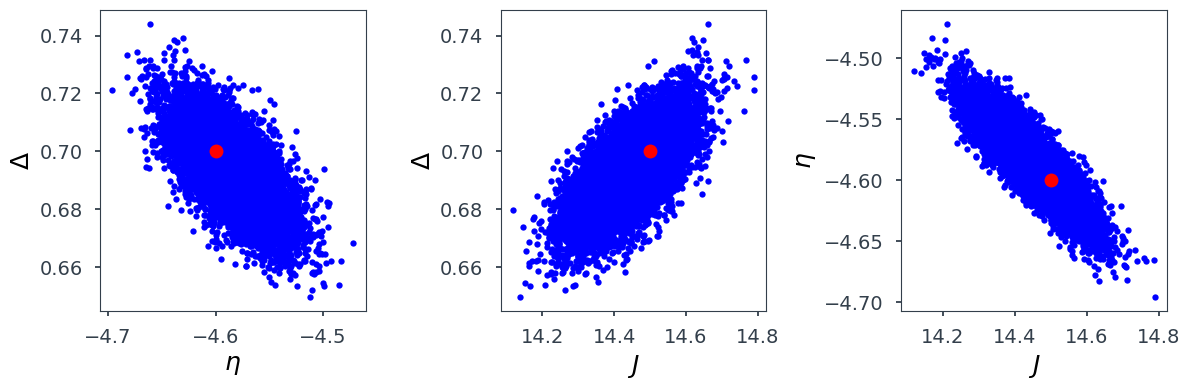

In [52]:
plt.figure(figsize=(12, 4))
plt.subplot(131)
plt.plot(eta_est, delta_est,'.', color='blue')
plt.plot(eta_true, delta_true,'o', color='red', markersize=10)
plt.xlabel("$\eta$", fontsize=18)
plt.ylabel("$\Delta$", fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.subplot(132)
plt.plot(J_est, delta_est, '.',color='blue')
plt.plot(J_true, delta_true, 'o', color='red', markersize=10)
plt.xlabel("$J$", fontsize=18)
plt.ylabel("$\Delta$",fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.subplot(133)
plt.plot(J_est, eta_est, '.', color='blue')
plt.plot(J_true, eta_true, 'o', color='red', markersize=10)
plt.xlabel("$J$", fontsize=18)
plt.ylabel("$\eta$", fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()
plt.savefig(os.path.join(cwd+'/'+str(Res_dir), "Monbtbrio_NMM_ode_Isin_posterior_PairParamsJoindist_obsI.png"), dpi=300)
plt.show()

In [53]:
delta_est=array([delta_est]).T
eta_est=array([eta_est]).T
J_est=array([J_est]).T

Here we put the posterior in DataFrame and we calculate the pearson correlation between them:

In [54]:
params = {'delta_est': delta_est, 'eta_est': eta_est, 'J_est': J_est}
        
f=concatenate((delta_est, eta_est, J_est), axis=1)

df = pd.DataFrame(f, columns=['delta_est',  'eta_est', 'J_est' ])

In [55]:
df.corr()

,delta_est,eta_est,J_est
delta_est,1.000000,-0.670676,0.682457
eta_est,-0.670676,1.000000,-0.868872
J_est,0.682457,-0.868872,1.000000


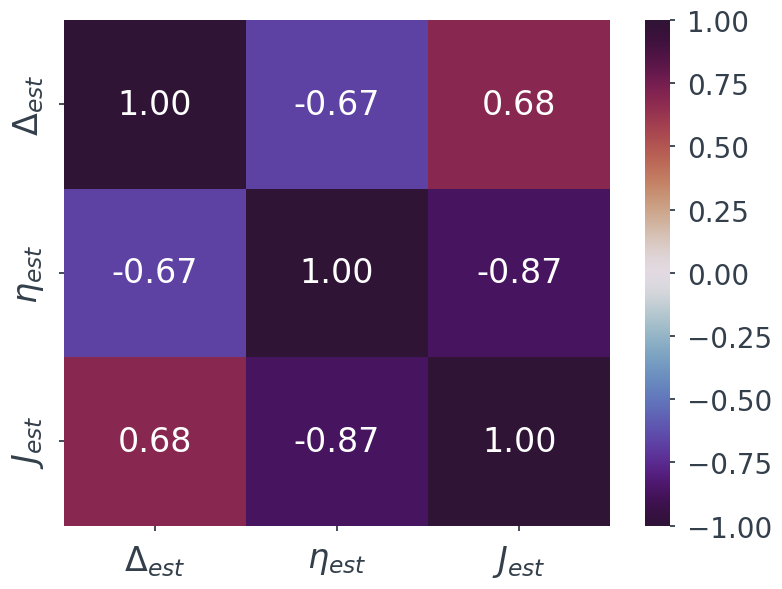

In [56]:
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111)
#cmap = sns.diverging_palette(240, 10, sep=20, as_cmap=True)
sns.heatmap(df.corr(), annot=True, robust=True, cmap='twilight_shifted', linewidths=.0, annot_kws={'size':24}, fmt=".2f", vmin=-1, vmax=1, ax=ax, xticklabels=['$\Delta_{est}$', '$\eta_{est}$', '$J_{est}$' ], yticklabels=['$\Delta_{est}$', '$\eta_{est}$', '$J_{est}$' ])
#ax.set_xticklabels()
#ax.set_yticklabels()
cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=20)
ax.tick_params(labelsize=24)
plt.tight_layout()
plt.savefig(os.path.join(cwd+'/'+str(Res_dir), "Monbtbrio_NMM_ode_Isin_posterior_CorrParams_obsI.png"), dpi=300)
plt.show()

Now we make posterior predictive check to see how is close the re-simuation from MAP is close to the observed data i.e., posterior predictive check (ppc).

In [57]:
x_fit= Montbrio_ODEmodel_numba(np.percentile(posterior_samples, [50], axis=0).reshape(-1), constants, I_input, dt, ts)
v_fit=x_fit[0:nt]
r_fit=x_fit[nt:2*nt]

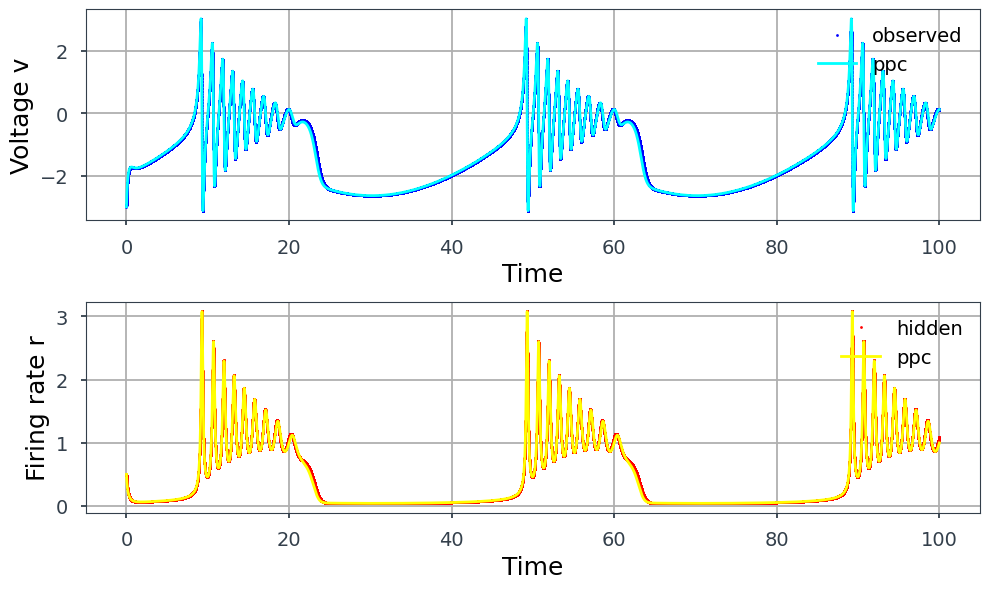

In [58]:
plt.figure(figsize=(10, 6))
plt.subplot(211)
plt.plot(ts, v_obs, '.',  markersize=4, color='blue', label='observed')
plt.plot(ts, v_fit, lw=2, color='cyan', label='ppc')
plt.xlabel('Time', fontsize=18)
plt.ylabel('Voltage v', fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(loc='upper right',fontsize=14, frameon=False)
plt.tight_layout()
plt.grid()

plt.subplot(212)
plt.plot(ts, r_obs, '.',  markersize=4, color='red',label='hidden')
plt.plot(ts, r_fit, lw=2, color='yellow', label='ppc')
plt.xlabel('Time', fontsize=18)
plt.ylabel('Firing rate r',fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(loc='upper right', fontsize=14, frameon=False)
plt.tight_layout()
plt.grid()
plt.savefig(os.path.join(cwd+'/'+str(Res_dir), "Monbtbrio_NMM_ode_Isin_fit_obsI.png"), dpi=300)
plt.show()

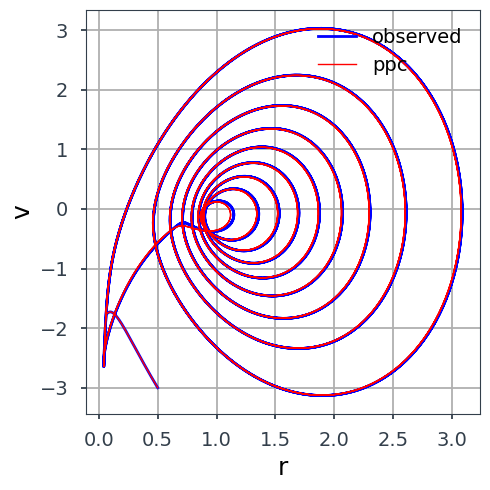

In [59]:
plt.figure(figsize=(5, 5))
plt.plot(r_obs, v_obs, 'b', linewidth=2, label='observed')
plt.plot(r_fit, v_fit, 'r', linewidth=1, label='ppc')
plt.ylabel('v', fontsize=18); 
plt.xlabel('r', fontsize=18);
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(loc='upper right',fontsize=14, frameon=False)
plt.grid()
plt.tight_layout()
plt.savefig(os.path.join(cwd+'/'+str(Res_dir), "Monbtbrio_NMM_ode_Isin_fitphaseplane_obsI.png"), dpi=300)
plt.show()

and finally  a sensitivity analysis:

In [60]:
sensitivity = ActiveSubspace(posterior.set_default_x(x_obs_summary_statistics))
e_vals, e_vecs = sensitivity.find_directions(posterior_log_prob_as_property=True)

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

In [61]:
print("Eigenvalues: \n", e_vals, "\n")
print("Eigenvectors: \n", e_vecs)

Eigenvalues: 
 tensor([0.0017, 0.0269, 0.0312]) 

Eigenvectors: 
 tensor([[-0.2481,  0.8950,  0.3708],
        [ 0.5336, -0.1932,  0.8234],
        [-0.8086, -0.4021,  0.4296]])


In [62]:
sensitivity_vals = pd.Series(1/e_vals, index=params_label)

df = pd.DataFrame({'sensitivity_vals' : sensitivity_vals})
df = df.sort_values(by='sensitivity_vals')
normalized_df=(df-df.min())/(df.max()-df.min())
my_range=list(range(1,len(df.index)+1))


In [63]:
normalized_df

,sensitivity_vals
$J$,0.000000
$\eta$,0.009001
$\Delta$,1.000000


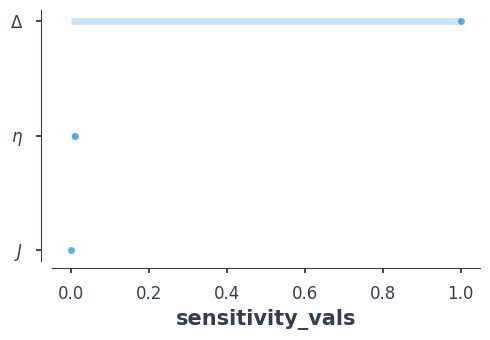

In [64]:
fig, ax = plt.subplots(figsize=(5,3.5))

plt.hlines(y=my_range, xmin=0, xmax=normalized_df, color='#007ACC', alpha=0.2, linewidth=5)
plt.plot(normalized_df, my_range, "o", markersize=5, color='#007ACC', alpha=0.6)
plt.yticks(my_range, df.index)
ax.set_xlabel('sensitivity_vals', fontsize=15, fontweight='black', color = '#333F4B')
ax.set_ylabel('')
ax.tick_params(axis='both', which='major', labelsize=12)
#ax.set_xlim(0,200)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_position(('outward', 8))
ax.spines['bottom'].set_position(('outward', 5))
plt.tight_layout()
plt.savefig(os.path.join(cwd+'/'+str(Res_dir), "sensitivity_vals_obsI.png"), dpi=300)
plt.show()

In [65]:
np.save(os.path.join(cwd+'/'+str(Res_dir), 'true_params_ode_Vfeatures100k_obsI.npy'), true_params)
np.save(os.path.join(cwd+'/'+str(Res_dir), 'posterior_samples_ode_Vfeatures100k_obsI.npy'), posterior_samples)
np.save(os.path.join(cwd+'/'+str(Res_dir), 'x_obs_ode_Vfeatures100k_obsI.npy'), x_obs)
np.save(os.path.join(cwd+'/'+str(Res_dir), 'x_fit_ode_Vfeatures100k_obsI.npy'), x_fit)

Since the SNPE with a single round of training is amortized, we can infer the parameters from any new observation. Lets try it! 

###  Observed Data II

This is another set of observed data that we aim to fit.

In [66]:
delta_true=0.4
eta_true=-4.
J_true=18.5

true_params = np.array([delta_true, eta_true, J_true])

In [67]:
x_obs= Montbrio_ODEmodel_numba(true_params, constants, I_input, dt, ts)
v_obs=x_obs[0:nt]
r_obs=x_obs[nt:2*nt]
x_obs_summary_statistics=calculate_summary_statistics(v_obs.reshape(-1), dt, ts, t_on, t_off)

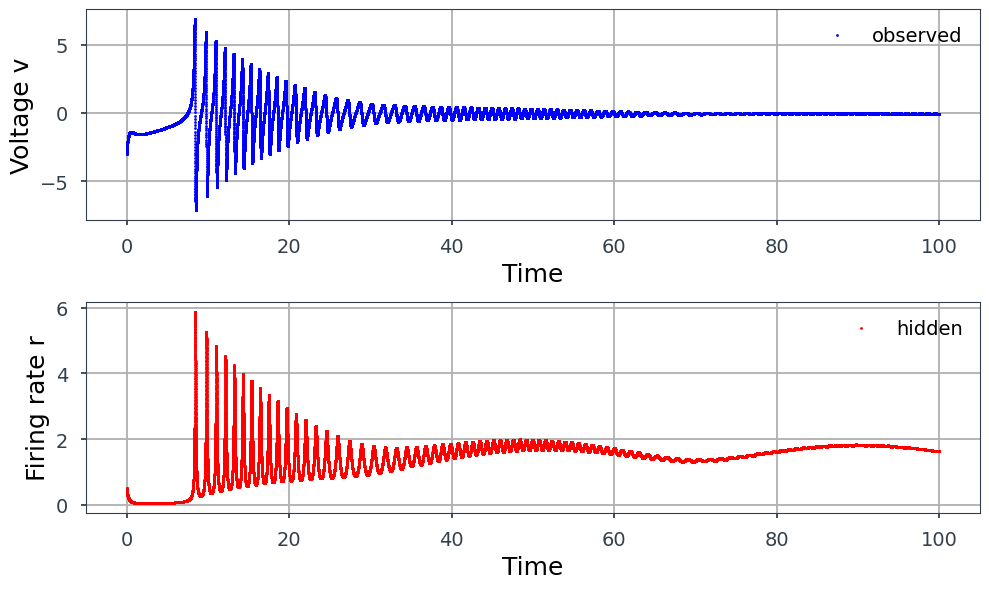

In [68]:
plt.figure(figsize=(10, 6))
plt.subplot(211)
plt.plot(ts, v_obs, '.',  markersize=4, color='blue', label='observed')
plt.xlabel('Time', fontsize=18)
plt.ylabel('Voltage v', fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(loc='upper right',fontsize=14, frameon=False)
plt.tight_layout()
plt.grid()

plt.subplot(212)
plt.plot(ts, r_obs, '.',  markersize=4, color='red',label='hidden')
plt.xlabel('Time', fontsize=18)
plt.ylabel('Firing rate r',fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(loc='upper right', fontsize=14, frameon=False)
plt.tight_layout()
plt.grid()
plt.savefig(os.path.join(cwd+'/'+str(Res_dir), "Monbtbrio_NMM_ode_Isin_obsII.png"), dpi=300)
plt.show()

### Posterior II

In [69]:
start_time = time.time()

posterior_samples = posterior.sample((num_samples,), x_obs_summary_statistics).numpy()

print ("-"*60)
print("--- posterior sampling took: %s seconds ---" % (time.time() - start_time))

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

------------------------------------------------------------
--- posterior sampling took: 0.07382082939147949 seconds ---


In [70]:
delta_est=posterior_samples[:,0]
eta_est=posterior_samples[:,1]
J_est=posterior_samples[:,2]

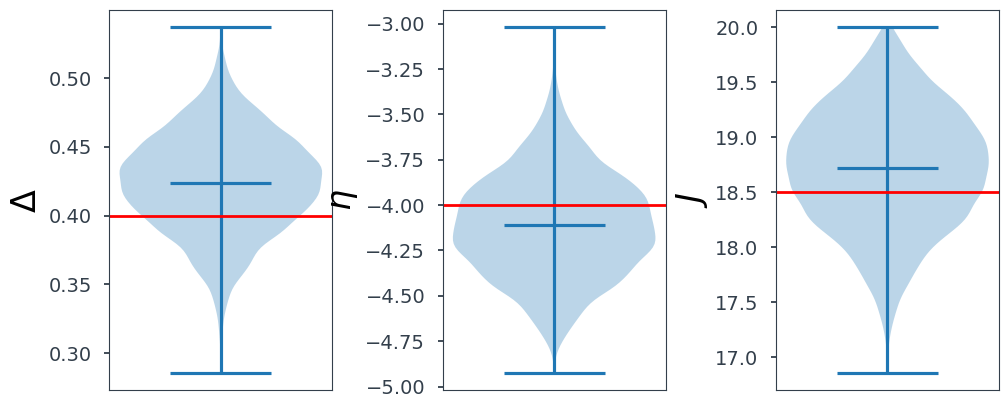

In [71]:
plt.figure(figsize=(10, 4))
for i, variables in enumerate([delta_est, eta_est, J_est]):
    plt.subplot(1,params_label.shape[0],i+1)
    plt.violinplot(variables, widths=0.7, showmeans=True, showextrema=True);
    plt.axhline(y=true_params[i], linewidth=2, color='r')
    plt.ylabel(str(params_label[i]), fontsize=24)   
    plt.xticks([])
    plt.yticks(fontsize=14)
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir), "PosteriorViloin_Monbtbrio_NMM_ode_Isin_EstimatedParams_obsII.png"), dpi=300)
plt.show()

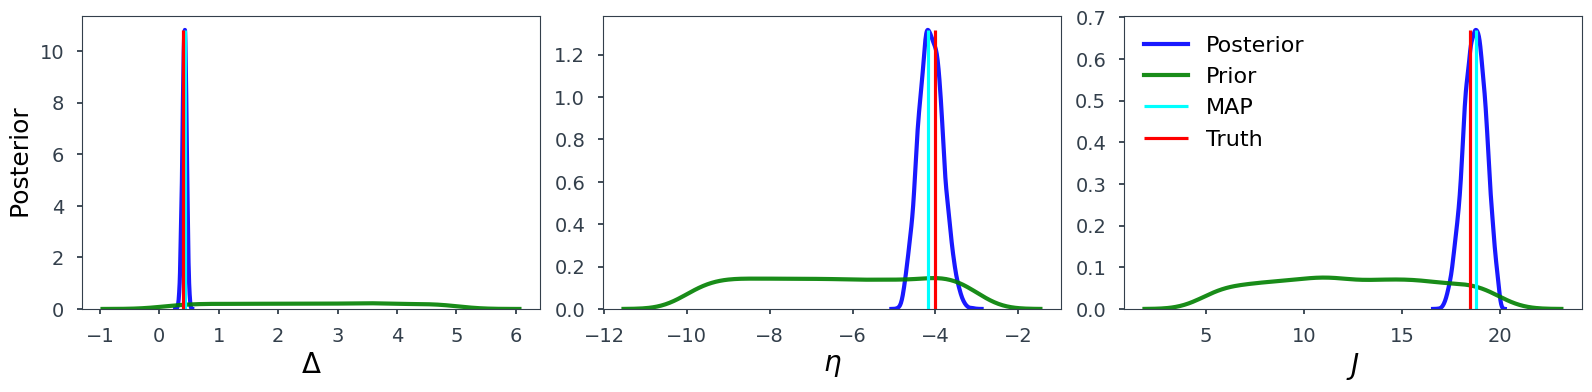

In [72]:
plt.figure(figsize=(16, 4))

for i in range (num_params): 
    ax = plt.subplot(1, 3, i + 1)
    
   
    ax=sns.distplot(posterior_samples[:,i], bins=100, hist=False, kde=True, rug=False, rug_kws={"alpha": 0.1, "color": "g"},
                  kde_kws={"color": "b", "alpha": 0.9, "lw": 3, "label": "Posterior"})
    
    ax_=sns.distplot(prior_samples[:,i], bins=100, hist=False, kde=True, rug=False, rug_kws={"alpha": 0.1, "color": "g"},
                  kde_kws={"color": "g", "alpha": 0.9, "lw": 3, "label": "Prior"})

    x_ = ax.lines[0].get_xdata()
    y_ = ax.lines[0].get_ydata()
    ymax = max(y_)
    xpos = np.argmax(y_, axis=0)
    xmax = x_[xpos]
    plt.vlines(x=xmax, ymin=0., ymax=y_.max(), colors='cyan', label='MAP')
    plt.vlines(x=true_params[i], ymin=0., ymax=y_.max(), colors='r', label='Truth')

    plt.xlabel(str(params_label[i]), fontsize=20)   
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)

    if i==0:
        plt.ylabel(' Posterior ', fontsize=18);  
    else:
        plt.ylabel('')
        
    if i==2:
            plt.legend(fontsize=16, frameon=False)
 
plt.tight_layout(pad=1.0)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir), "Posterior_Monbtbrio_NMM_ode_Isin_EstimatedParamswithPrior_obsII.png"), dpi=300)
plt.show()

In [73]:
x_fit= Montbrio_ODEmodel_numba(np.percentile(posterior_samples, [50], axis=0).reshape(-1), constants, I_input, dt, ts)
v_fit=x_fit[0:nt]
r_fit=x_fit[nt:2*nt]

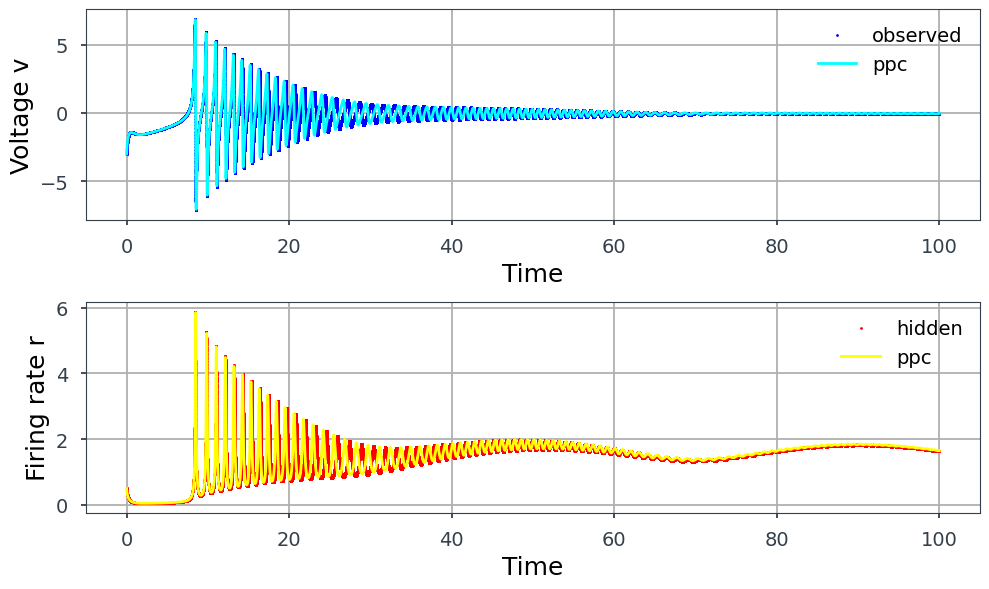

In [74]:
plt.figure(figsize=(10, 6))
plt.subplot(211)
plt.plot(ts, v_obs, '.',  markersize=4, color='blue', label='observed')
plt.plot(ts, v_fit, lw=2, color='cyan', label='ppc')
plt.xlabel('Time', fontsize=18)
plt.ylabel('Voltage v', fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(loc='upper right',fontsize=14, frameon=False)
plt.tight_layout()
plt.grid()

plt.subplot(212)
plt.plot(ts, r_obs, '.',  markersize=4, color='red',label='hidden')
plt.plot(ts, r_fit, lw=2, color='yellow', label='ppc')
plt.xlabel('Time', fontsize=18)
plt.ylabel('Firing rate r',fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(loc='upper right', fontsize=14, frameon=False)
plt.tight_layout()
plt.grid()
plt.savefig(os.path.join(cwd+'/'+str(Res_dir), "Monbtbrio_NMM_ode_Isin_fit_obsII.png"), dpi=300)
plt.show()

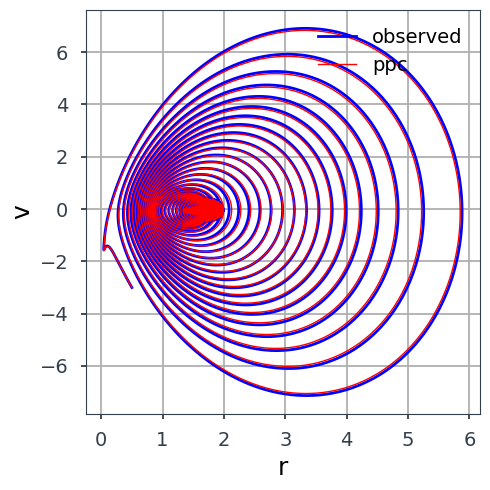

In [75]:
plt.figure(figsize=(5, 5))
plt.plot(r_obs, v_obs, 'b', linewidth=2, label='observed')
plt.plot(r_fit, v_fit, 'r', linewidth=1, label='ppc')
plt.ylabel('v', fontsize=18); 
plt.xlabel('r', fontsize=18);
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(loc='upper right',fontsize=14, frameon=False)
plt.grid()
plt.tight_layout()
plt.savefig(os.path.join(cwd+'/'+str(Res_dir), "Monbtbrio_NMM_ode_Isin_fitphaseplane_obsII.png"), dpi=300)
plt.show()

###  Observed Data III

This is another set of observed data that we aim to fit.

In [76]:
delta_true=1.5
eta_true=-5.
J_true=10.

true_params = np.array([delta_true, eta_true, J_true])

In [77]:
x_obs= Montbrio_ODEmodel_numba(true_params, constants, I_input, dt, ts)
v_obs=x_obs[0:nt]
r_obs=x_obs[nt:2*nt]
x_obs_summary_statistics=calculate_summary_statistics(v_obs.reshape(-1), dt, ts, t_on, t_off)

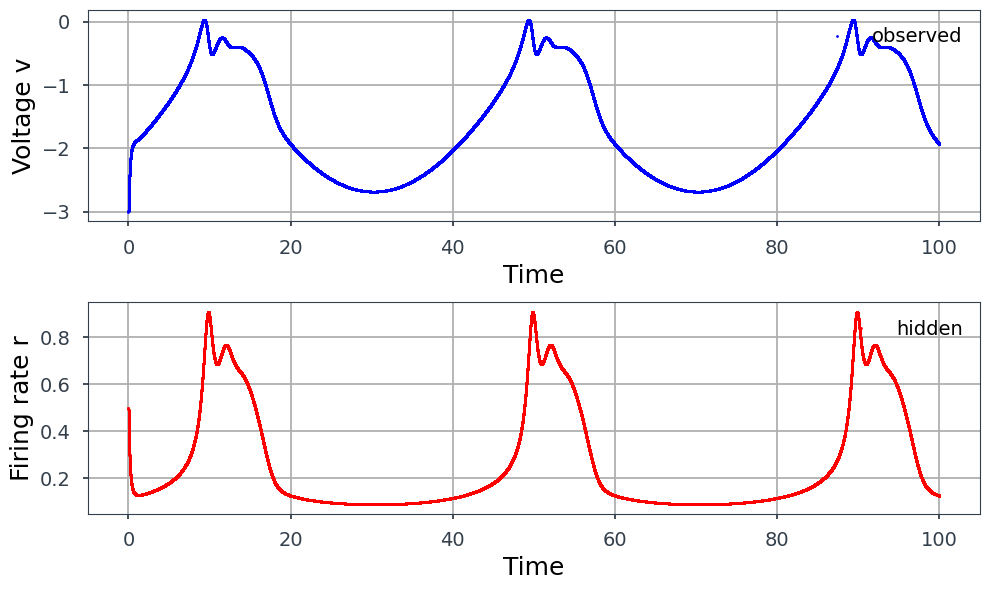

In [78]:
plt.figure(figsize=(10, 6))
plt.subplot(211)
plt.plot(ts, v_obs, '.',  markersize=4, color='blue', label='observed')
plt.xlabel('Time', fontsize=18)
plt.ylabel('Voltage v', fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(loc='upper right',fontsize=14, frameon=False)
plt.tight_layout()
plt.grid()

plt.subplot(212)
plt.plot(ts, r_obs, '.',  markersize=4, color='red',label='hidden')
plt.xlabel('Time', fontsize=18)
plt.ylabel('Firing rate r',fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(loc='upper right', fontsize=14, frameon=False)
plt.tight_layout()
plt.grid()

plt.savefig(os.path.join(cwd+'/'+str(Res_dir), "Monbtbrio_NMM_ode_Isin_obsIII.png"), dpi=300)
plt.show()

### Posterior III

In [79]:
start_time = time.time()

posterior_samples = posterior.sample((num_samples,), x_obs_summary_statistics).numpy()

print ("-"*60)
print("--- posterior sampling took: %s seconds ---" % (time.time() - start_time))


Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

------------------------------------------------------------
--- posterior sampling took: 0.07287907600402832 seconds ---


In [80]:
delta_est=posterior_samples[:,0]
eta_est=posterior_samples[:,1]
J_est=posterior_samples[:,2]

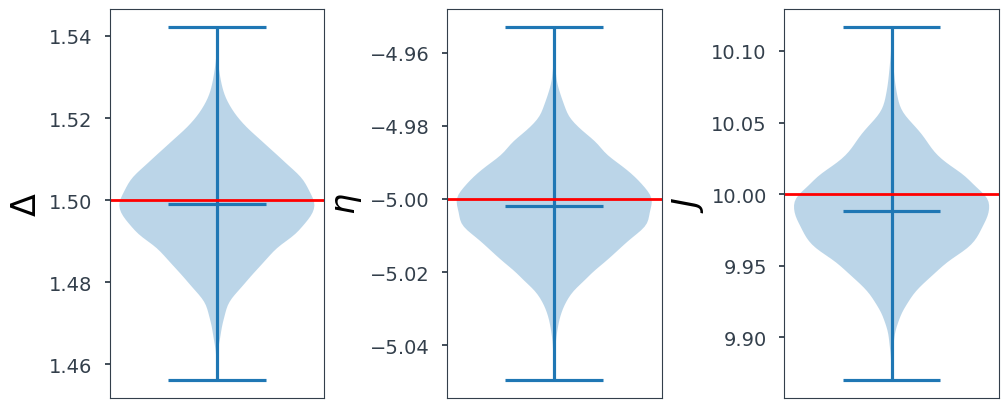

In [81]:
plt.figure(figsize=(10, 4))
for i, variables in enumerate([delta_est, eta_est, J_est]):
    plt.subplot(1,params_label.shape[0],i+1)
    plt.violinplot(variables, widths=0.7, showmeans=True, showextrema=True);
    plt.axhline(y=true_params[i], linewidth=2, color='r')
    plt.ylabel(str(params_label[i]), fontsize=24)   
    plt.xticks([])
    plt.yticks(fontsize=14)
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir), "PosteriorViloin_Monbtbrio_NMM_ode_Isin_EstimatedParams_obsII.png"), dpi=300)
plt.show()

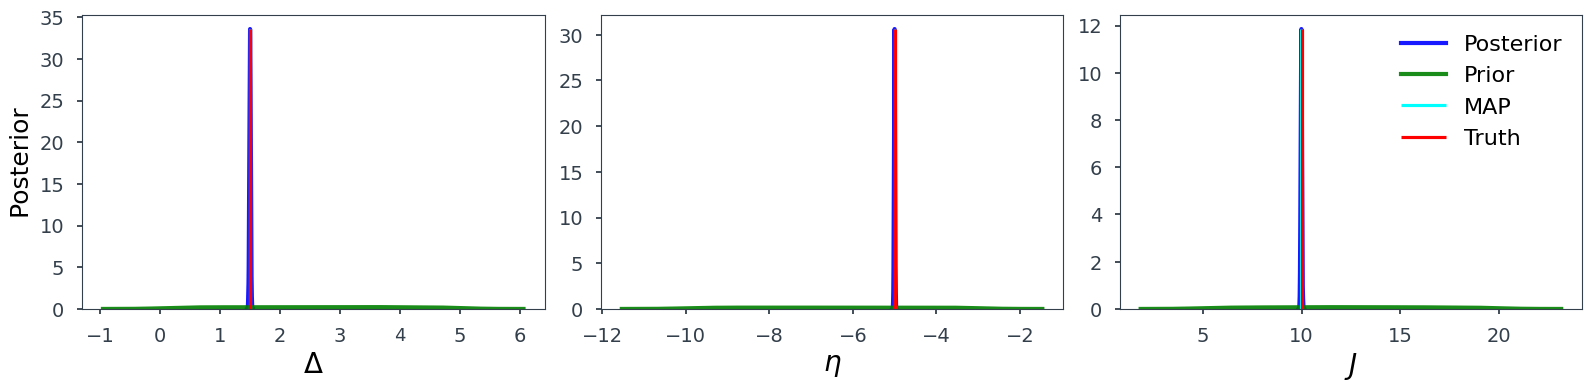

In [82]:
plt.figure(figsize=(16, 4))

for i in range (num_params): 
    ax = plt.subplot(1, 3, i + 1)
    
   
    ax=sns.distplot(posterior_samples[:,i], bins=100, hist=False, kde=True, rug=False, rug_kws={"alpha": 0.1, "color": "g"},
                  kde_kws={"color": "b", "alpha": 0.9, "lw": 3, "label": "Posterior"})
    
    ax_=sns.distplot(prior_samples[:,i], bins=100, hist=False, kde=True, rug=False, rug_kws={"alpha": 0.1, "color": "g"},
                  kde_kws={"color": "g", "alpha": 0.9, "lw": 3, "label": "Prior"})

    x_ = ax.lines[0].get_xdata()
    y_ = ax.lines[0].get_ydata()
    ymax = max(y_)
    xpos = np.argmax(y_, axis=0)
    xmax = x_[xpos]
    plt.vlines(x=xmax, ymin=0., ymax=y_.max(), colors='cyan', label='MAP')
    plt.vlines(x=true_params[i], ymin=0., ymax=y_.max(), colors='r', label='Truth')

    plt.xlabel(str(params_label[i]), fontsize=20)   
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)

    if i==0:
        plt.ylabel(' Posterior ', fontsize=18);  
    else:
        plt.ylabel('')
        
    if i==2:
            plt.legend(fontsize=16, frameon=False)
 
plt.tight_layout(pad=1.0)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir), "Posterior_Monbtbrio_NMM_ode_Isin_EstimatedParamswithPrior_obsIII.png"), dpi=300)
plt.show()

In [83]:
x_fit= Montbrio_ODEmodel_numba(np.percentile(posterior_samples, [50], axis=0).reshape(-1), constants, I_input, dt, ts)
v_fit=x_fit[0:nt]
r_fit=x_fit[nt:2*nt]

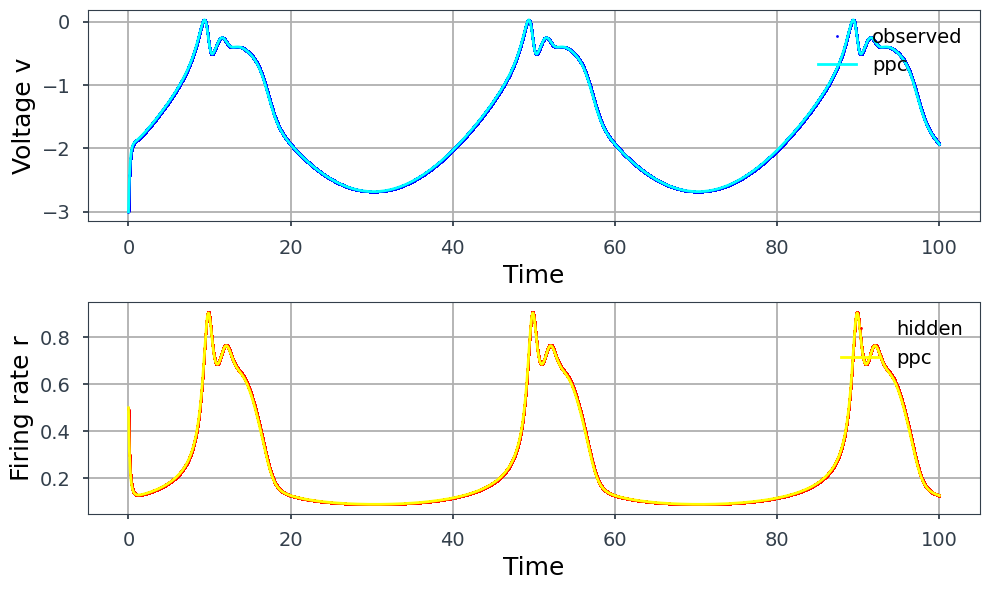

In [84]:
plt.figure(figsize=(10, 6))
plt.subplot(211)
plt.plot(ts, v_obs, '.',  markersize=4, color='blue', label='observed')
plt.plot(ts, v_fit, lw=2, color='cyan', label='ppc')
plt.xlabel('Time', fontsize=18)
plt.ylabel('Voltage v', fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(loc='upper right',fontsize=14, frameon=False)
plt.tight_layout()
plt.grid()

plt.subplot(212)
plt.plot(ts, r_obs, '.',  markersize=4, color='red',label='hidden')
plt.plot(ts, r_fit, lw=2, color='yellow', label='ppc')
plt.xlabel('Time', fontsize=18)
plt.ylabel('Firing rate r',fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(loc='upper right', fontsize=14, frameon=False)
plt.tight_layout()
plt.grid()
plt.savefig(os.path.join(cwd+'/'+str(Res_dir), "Monbtbrio_NMM_ode_Isin_fit_obsIII.png"), dpi=300)
plt.show()

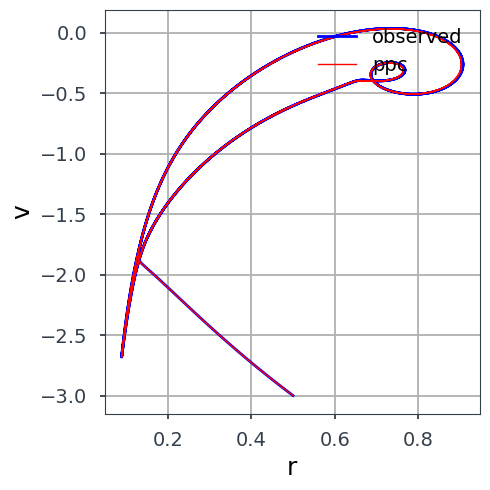

In [85]:
plt.figure(figsize=(5, 5))
plt.plot(r_obs, v_obs, 'b', linewidth=2, label='observed')
plt.plot(r_fit, v_fit, 'r', linewidth=1, label='ppc')
plt.ylabel('v', fontsize=18); 
plt.xlabel('r', fontsize=18);
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(loc='upper right',fontsize=14, frameon=False)
plt.grid()
plt.tight_layout()
plt.savefig(os.path.join(cwd+'/'+str(Res_dir), "Monbtbrio_NMM_ode_Isin_fitphaseplane_obsIII.png"), dpi=300)
plt.show()